# Question 1: Control VAE

* Dataset -  dSprites (2D shape)
* Models: VAE | Control VAE

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import os
import seaborn as sns
from sklearn.model_selection import train_test_split

import shutil
from google.colab import drive
from google.colab import files

import requests
import zipfile
import io

from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, accuracy_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions
import torch.optim as optim
import torch


from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Lambda, Reshape, Flatten, LeakyReLU, Softmax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Progbar
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import cv2
import random
import click

## 1-1. Intro - load data

In [2]:
drive.mount('/content/drive')


Mounted at /content/drive


In [25]:
file_name = "sh3_sc6_y32_x32_imgs.npz"
path_file = "/content/drive/MyDrive/Dataset/sh3_sc6_y32_x32_imgs.npz"
imgs = np.load(path_file, allow_pickle=True, encoding='latin1')
imgs = imgs['imgs']

In [26]:
for i in range(10):
    print(f"Image {i + 1} size: {imgs[i].shape}")

Image 1 size: (64, 64)
Image 2 size: (64, 64)
Image 3 size: (64, 64)
Image 4 size: (64, 64)
Image 5 size: (64, 64)
Image 6 size: (64, 64)
Image 7 size: (64, 64)
Image 8 size: (64, 64)
Image 9 size: (64, 64)
Image 10 size: (64, 64)


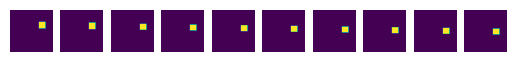

In [6]:
import matplotlib.pyplot as plt


num_samples_to_display = 10

for i in range(num_samples_to_display):
    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(imgs[i+1000])
    plt.axis('off')

plt.show()


## Dataloader

In [27]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

class DspritesDataset(Dataset):
    def __init__(self, imgs):
        self.data = imgs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.from_numpy(self.data[idx]).float()
        sample = sample.unsqueeze(0)
        return sample

def load_dsprites(file_name, path_file, batch_size=64, validation_split=0.2, shuffle_dataset=True, random_seed=42):
    # Load the dataset
    imgs = np.load(path_file, allow_pickle=True, encoding='latin1')['imgs']

    # Define the transformations
    transform = transforms.Compose([transforms.ToTensor()])

    # Create the dataset
    dataset = DspritesDataset(imgs)

    # Split the dataset into training and validation sets
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))

    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    # Create data loaders
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

    return train_loader, val_loader

# Example usage
file_name = "sh3_sc6_y32_x32_imgs.npz"
path_file = "/content/drive/MyDrive/Dataset/sh3_sc6_y32_x32_imgs.npz"
train_loader, val_loader = load_dsprites(file_name, path_file, batch_size=64, validation_split=0.2)


In [ ]:
train_loader

In [ ]:
print("Image shape:", imgs[0].shape)

Image shape: (64, 64)


## VAE For Test

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

class VAE_Simple(nn.Module):
    def __init__(self, input_size=64*64, hidden_size=256, latent_size=10):
        super(VAE_Simple, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_size)
        self.fc22 = nn.Linear(hidden_size, latent_size)
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, input_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 64*64))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 64*64), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

model = VAE_Simple()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def accuracy(recon_x, x):
    # Use a threshold to determine predicted class
    predicted = recon_x.view(-1) > 0.5
    correct = (predicted == x.view(-1).byte()).float()
    acc = correct.sum() / x.numel()
    return acc.item()


# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_acc = 0.0

    for data in train_loader:
        inputs = data.float()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(inputs)
        loss = loss_function(recon_batch, inputs, mu, logvar)
        acc = accuracy(recon_batch, inputs)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += acc

    average_loss = total_loss / len(train_loader.dataset)
    average_acc = total_acc / len(train_loader.dataset)

    print(f'Train Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}, Acc: {average_acc:.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for data in val_loader:
            inputs = data.float()
            recon_batch, mu, logvar = model(inputs)
            loss = loss_function(recon_batch, inputs, mu, logvar)
            acc = accuracy(recon_batch, inputs)

            val_loss += loss.item()
            val_acc += acc

    average_val_loss = val_loss / len(val_loader.dataset)
    average_val_acc = val_acc / len(val_loader.dataset)

    print(f'Validation Epoch {epoch + 1}/{num_epochs}, Loss: {average_val_loss:.4f}, Acc: {average_val_acc:.4f}')


Train Epoch 1/2, Loss: 1053.4529, Acc: 0.0113
Validation Epoch 1/2, Loss: 157.5542, Acc: 0.0030
Train Epoch 2/2, Loss: 497.7572, Acc: 0.0120
Validation Epoch 2/2, Loss: 93.8927, Acc: 0.0030


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(128*8*8, 64)
        self.fc_logvar = nn.Linear(128*8*8, 64)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 128*8*8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

# Instantiate the model and set up the optimizer
vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
for epoch in range(2):  # Change the number of epochs as needed
    vae.train()
    for data in train_loader:
        inputs = data.float()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = vae(inputs)

        # Compute the reconstruction loss and the KL divergence
        reconstruction_loss = F.binary_cross_entropy(recon_batch, inputs, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss
        loss = reconstruction_loss + kl_divergence

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        print("Epoch {}, Loss: {:.4f}".format(epoch + 1, loss.item()))


Epoch 1, Loss: 200343.4844
Epoch 1, Loss: 187094.2344
Epoch 1, Loss: 161637.2344
Epoch 1, Loss: 111929.9141
Epoch 1, Loss: 248640.4375
Epoch 1, Loss: 86558.6094
Epoch 1, Loss: 74277.8281
Epoch 1, Loss: 77315.6328
Epoch 1, Loss: 75913.8672
Epoch 1, Loss: 72406.0391
Epoch 1, Loss: 65561.2969
Epoch 1, Loss: 59326.8242
Epoch 1, Loss: 58188.1836
Epoch 1, Loss: 50564.7227
Epoch 1, Loss: 57239.1797
Epoch 1, Loss: 58016.9258
Epoch 1, Loss: 59292.4570
Epoch 1, Loss: 55560.2305
Epoch 1, Loss: 52384.4922
Epoch 1, Loss: 51773.2383
Epoch 1, Loss: 49927.4961
Epoch 1, Loss: 47015.9727
Epoch 1, Loss: 52367.4609
Epoch 1, Loss: 46226.6172
Epoch 1, Loss: 47960.8438
Epoch 1, Loss: 45853.7656
Epoch 1, Loss: 40178.5938
Epoch 1, Loss: 38617.7422
Epoch 1, Loss: 40911.1875
Epoch 1, Loss: 38808.9922
Epoch 1, Loss: 42135.5156
Epoch 1, Loss: 43340.3281
Epoch 1, Loss: 38395.1719
Epoch 1, Loss: 40507.4883
Epoch 1, Loss: 40143.1719
Epoch 1, Loss: 42428.0625
Epoch 1, Loss: 45997.1875
Epoch 1, Loss: 41528.4766
Epoch 1

In [ ]:
for epoch in range(2):  # Change the number of epochs as needed
    model.train()
    for data in train_loader:
        inputs = data.float()
        print("Input shape: (barch | channel | height and width)", inputs.size())

Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64, 1, 64, 64])
Input shape: (barch | channel | height and width) torch.Size([64

## VAE Beta For Test

In [18]:
'''
Loss Functions
'''

def kl_divergence_stdnorm(z_mean, z_log_sigma):

  kl = -0.5*K.mean(K.sum(1 + 2*z_log_sigma - K.square(z_mean) - K.exp(2*z_log_sigma), axis=1))
  return kl

def reconstruction_ll(x_true, x_prob_logit):

  x_true = K.batch_flatten(x_true)
  x_prob_logit = K.batch_flatten(x_prob_logit)

  ce = K.binary_crossentropy(x_true, x_prob_logit, from_logits=True)
  ce = K.sum(ce, axis=1)
  ce = K.mean(ce)

  return ce
def beta_vae_loss(x_true, z_mean, z_log_sigma, x_rec_logit, beta=4.0):

  reconstruction_l = reconstruction_ll(x_true, x_rec_logit)
  kl_divergence = kl_divergence_stdnorm(z_mean, z_log_sigma)

  beta_vae_l = reconstruction_l + beta*kl_divergence

  return beta_vae_l, reconstruction_l, kl_divergence


'''
Utility Functions
'''

def norm_sampling(mean, log_stdev):

  epsilon = K.random_normal(shape=K.shape(mean))

  return mean + K.exp(log_stdev) * epsilon

def permute_dims(z):

  shuffled_features = [K.expand_dims(tf.random.shuffle(z[:,i]), axis=-1) for i in range(K.int_shape(z)[1])]
  shuffled = K.concatenate(shuffled_features, axis=-1)

  return shuffled


In [16]:
class Encoder(Model):

  def __init__(self, latent_dims):
    super(Encoder, self).__init__(name='encoder')

    self.latent_dims = latent_dims

    self.reshape_input = Reshape((64,64,1), input_shape=(64,64))
    self.hidden_layers = [Conv2D(32, kernel_size=(4,4), strides=(2,2), activation='relu', padding='same') for _ in range(2)]
    self.hidden_layers += [Conv2D(64, kernel_size=(4,4), strides=(2,2), activation='relu', padding='same') for _ in range(2)]
    self.hidden_layers += [Flatten(), Dense(128)]

    self.means = Dense(self.latent_dims)
    self.log_stdevs = Dense(self.latent_dims)

  def call(self, x):

    x = self.reshape_input(x)
    for h in self.hidden_layers:
      x = h(x)

    return self.means(x), self.log_stdevs(x)



class Decoder(Model):

  def __init__(self, latent_dims):
    super(Decoder, self).__init__(name='decoder')

    self.latent_dims = latent_dims

    self.hidden_layers = [
      Dense(128, activation='relu', input_shape=(self.latent_dims,)),
      Dense(4*4*64, activation='relu'),
      Reshape((4, 4, 64)),
      Conv2DTranspose(64, kernel_size=(4,4), strides=(2,2), activation='relu', padding='same'),
      Conv2DTranspose(64, kernel_size=(4,4), strides=(2,2), activation='relu', padding='same'),
      Conv2DTranspose(32, kernel_size=(4,4), strides=(2,2), activation='relu', padding='same'),
      Conv2DTranspose(1, kernel_size=(4,4), strides=(2,2), padding='same'),
      Reshape((64, 64))
    ]

  def call(self, x):

    for h in self.hidden_layers:
      x = h(x)

    return x

In [19]:
class BetaVAE():

  def __init__(self, latent_dims=10, beta=4.0):
    super(BetaVAE, self).__init__()

    self.beta = beta
    self.latent_dims = latent_dims

    self.encoder = Encoder(latent_dims)
    self.decoder = Decoder(latent_dims)

  def fit(self, X, batch_size=64):

    X_train, X_val = train_test_split(X, train_size=0.75, test_size=0.25, random_state=38, shuffle=True)

    X_train_ds = tf.data.Dataset.from_tensor_slices(X_train)
    X_train_ds = X_train_ds.shuffle(buffer_size=1024).batch(batch_size)

    beta_vae_optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999)

    iterations_per_epoch = X_train.shape[0]/batch_size
    iterations = 3e5
    n_epochs = int(iterations/iterations_per_epoch)

    for epoch in range(0, n_epochs):
      print("Epoch %d/%d" % (epoch+1, n_epochs))

      bar = Progbar(X_train.shape[0], stateful_metrics=["val_loss"], verbose=1)

      last_step = int(np.ceil(X_train.shape[0]/batch_size)) - 1
      for step, x_batch in enumerate(X_train_ds):
        beta_vae_l, rec_l, kl_div = self._train_step(x_batch, beta_vae_optimizer)

        if step == last_step:
          val_beta_vae_l, val_rec_l, val_kl_div = self._evaluate(X_val)
          bar.add(x_batch.shape[0],
                  values=[
                    ("loss", beta_vae_l),
                    ("rec_loss", rec_l),
                    ("kl_div", kl_div),
                    ("val_loss", val_beta_vae_l),
                    ("val_rec_loss", val_rec_l),
                    ("val_kl_div", val_kl_div),
                  ])

        else:
          bar.add(x_batch.shape[0],
                  values=[
                    ("loss", beta_vae_l),
                    ("rec_loss", rec_l),
                    ("kl_div", kl_div),
                  ])

  @tf.function
  def _train_step(self, X, optimizer):

    with tf.GradientTape() as tape:

      z_mean, z_stdev = self.encoder(X)
      samples = norm_sampling(z_mean, z_stdev)
      z_rec = self.decoder(samples)

      beta_vae_l, rec_l, kl_div = beta_vae_loss(X, z_mean, z_stdev, z_rec, self.beta)

    # optimize VAE
    variables = self.encoder.trainable_variables + self.decoder.trainable_variables
    grad = tape.gradient(beta_vae_l, variables)

    optimizer.apply_gradients(zip(grad, variables))

    return beta_vae_l, rec_l, kl_div

  @tf.function
  def _evaluate(self, X):

    z_mean, z_stdev = self.encoder(X)
    samples = norm_sampling(z_mean, z_stdev)
    z_rec = self.decoder(samples)

    beta_vae_l, rec_l, kl_div = beta_vae_loss(X, z_mean, z_stdev, z_rec, self.beta)

    return beta_vae_l, rec_l, kl_div

## 1-2. Implementation VAE ( Beta )
* Optimizer  Adam
* with β1 = 0.90, β2 = 0.99
* Leaning rate 0.0001
* Reconstruction loss Bernoull

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class BetaVAE(nn.Module):
    def __init__(self, beta=1.0):
        super(BetaVAE, self).__init__()
        self.beta = beta

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 256, kernel_size=4),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 20)  # 2 * 10 for mean and logvar
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Unflatten(1, (256, 2, 2)),
            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu_logvar = self.encoder(x)
        mu, logvar = torch.split(mu_logvar, 10, dim=1)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)

        # Compute the reconstruction loss and the KL divergence with the beta factor
        reconstruction_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss with the beta factor
        loss = reconstruction_loss + self.beta * kl_divergence

        return x_recon, mu, logvar, loss

# Instantiate the model and set up the optimizer
beta_vae = BetaVAE(beta=1.0)
optimizer = optim.Adam(beta_vae.parameters(), lr=0.0001, betas=(0.90, 0.99))

# Training loop
for epoch in range(2):  # Change the number of epochs as needed
    beta_vae.train()
    for data in train_loader:
        inputs = data.float()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar, loss = beta_vae(inputs)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        print("Epoch {}, Loss: {:.4f}".format(epoch + 1, loss.item()))


Epoch 1, Loss: 155842.7500
Epoch 1, Loss: 155949.5469
Epoch 1, Loss: 155797.6875
Epoch 1, Loss: 155590.2500
Epoch 1, Loss: 155356.2969
Epoch 1, Loss: 155547.5938
Epoch 1, Loss: 155371.6562
Epoch 1, Loss: 155357.4531
Epoch 1, Loss: 155043.5312
Epoch 1, Loss: 155252.4219
Epoch 1, Loss: 155111.6875
Epoch 1, Loss: 154860.8594
Epoch 1, Loss: 154564.0312
Epoch 1, Loss: 154555.6875
Epoch 1, Loss: 154348.1406
Epoch 1, Loss: 154239.6250
Epoch 1, Loss: 154339.8594
Epoch 1, Loss: 153813.6406
Epoch 1, Loss: 153790.4219
Epoch 1, Loss: 153519.4844
Epoch 1, Loss: 153496.7812
Epoch 1, Loss: 152791.3125
Epoch 1, Loss: 152693.3438
Epoch 1, Loss: 152259.1094
Epoch 1, Loss: 151806.5000
Epoch 1, Loss: 151066.5156
Epoch 1, Loss: 150532.8281
Epoch 1, Loss: 149473.1406
Epoch 1, Loss: 149202.9531
Epoch 1, Loss: 146973.3750
Epoch 1, Loss: 146488.2031
Epoch 1, Loss: 144411.2188
Epoch 1, Loss: 142339.2188
Epoch 1, Loss: 140985.5156
Epoch 1, Loss: 137807.2812
Epoch 1, Loss: 134441.0312
Epoch 1, Loss: 131069.5469
E